Notebook objective: Train & test fixed effects linear model with target encoding. Goal is to compare performance, SHAP values & fixed effects with LMM.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

## Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./OutputData/training_data.csv")

In [5]:
# Split features, groupings and target
X = df.drop(["life_expectancy"], axis = 1)
y = df.life_expectancy

In [6]:
# Create preprocessing pipeline
encoder = TargetEncoder(cols = "country")
scaler = MinMaxScaler()
pipeline = Pipeline([
    ("encoder", encoder), 
    ("scaler", scaler)
])

In [7]:
pipeline

Pipeline(steps=[('encoder', TargetEncoder(cols='country')),
                ('scaler', MinMaxScaler())])

In [8]:
# Create cv splitter
cv = GroupKFold(n_splits = 4)

## Testing & diagnostics

In [9]:
# Initialize lists to store validation results
train_list = []
val_list = []
preds_list = []
resids_list = []
fitted_list = []
fitres_list = []
scores_mse = []
scores_rmse = []
scores_mape = []

In [10]:
# Perform crossvalidation
for i, (train_index, val_index) in enumerate(cv.split(X = X, groups = X.country)):

    # Split train - val
    X_train, y_train = X.iloc[train_index, ], y[train_index]
    X_val, y_val = X.iloc[val_index, ], y[val_index]

    # Preprocess features
    X_train = pipeline.fit_transform(X_train, y_train)
    X_val = pipeline.transform(X_val)

    # Train fixed effects model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Save actual values
    train_list.append(y_train)
    val_list.append(y_val)

    # Make predictions on test data
    preds = model.predict(X_val)
    preds_list.append(preds)

    # Calculate prediction residuals
    resids = y_val - preds
    resids_list.append(resids)

    # Get fitted values
    fitted = model.predict(X_train)
    fitted_list.append(fitted)

    # Get fitted residuals
    fitted_resids = y_train - fitted
    fitres_list.append(fitted_resids)

    # Calculate scores
    mse = mean_squared_error(y_val, preds)
    scores_mse.append(mse)

    rmse = mean_squared_error(y_val, preds, squared = False)
    scores_rmse.append(rmse)

    mape = mean_absolute_percentage_error(y_val, preds)
    scores_mape.append(mape)


In [11]:
# Print average MSE, RMSE, MAPE
print("MSE:")
print(round(np.mean(scores_mse), 4))

print("RMSE:")
print(round(np.mean(scores_rmse), 4))

print("MAPE:")
print(round(np.mean(scores_mape), 4))

MSE:
55.426
RMSE:
7.4383
MAPE:
0.0926


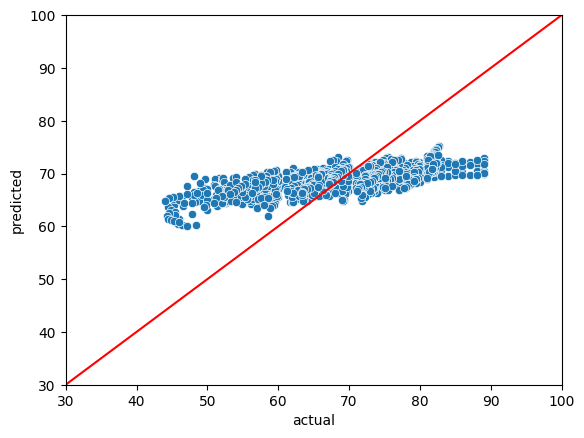

In [12]:
# Plot predicted vs. actual
_ = sns.scatterplot(
    x = np.concatenate(val_list).ravel(),  
    y = np.concatenate(preds_list).ravel()
)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

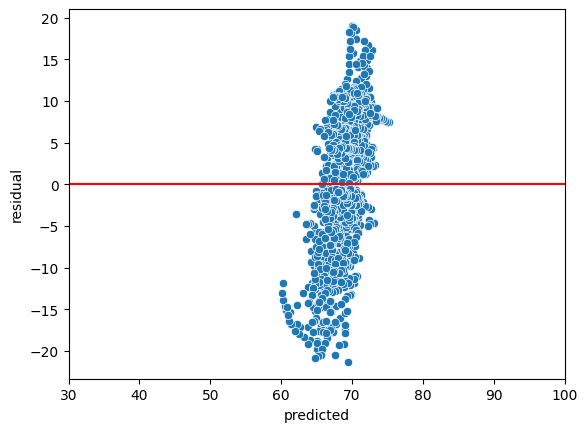

In [13]:
# Predicted vs residual
_ = sns.scatterplot(
    x = np.concatenate(preds_list).ravel(), 
    y = np.concatenate(resids_list).ravel()
)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
#_ = plt.ylim(-30, 30)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

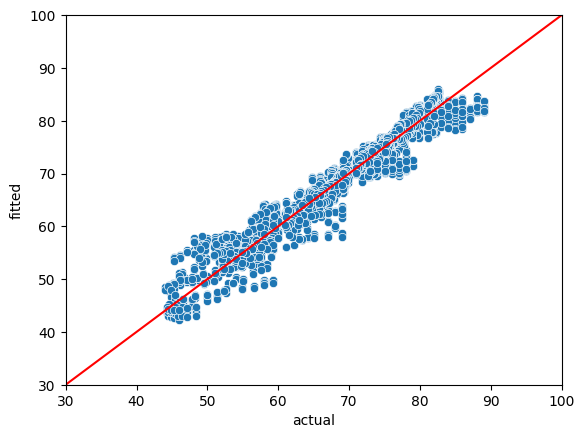

In [14]:
# Plot fitted vs. actual
_ = sns.scatterplot(
    x = np.concatenate(train_list).ravel(),  
    y = np.concatenate(fitted_list).ravel()
)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("fitted")

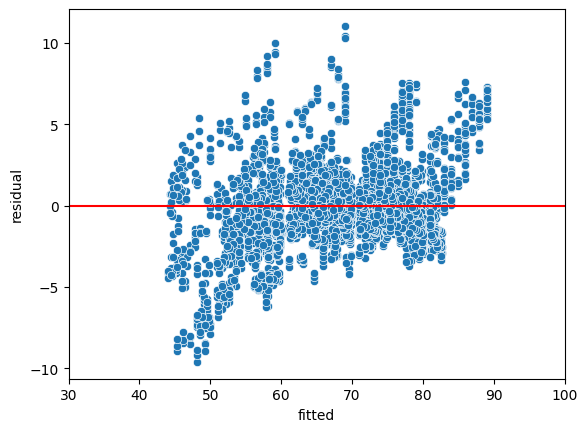

In [15]:
# Plot fitted vs. residual
_ = sns.scatterplot(
    x = np.concatenate(train_list).ravel(), 
    y = np.concatenate(fitres_list).ravel()
)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
#_ = plt.ylim(-30, 30)
_ = plt.xlabel("fitted")
_ = plt.ylabel("residual")

## Inference

In [16]:
# Train final model
model = LinearRegression()
X_scaled = pd.DataFrame(pipeline.fit_transform(X, y), columns = X.columns)
model.fit(X_scaled, y)

LinearRegression()

In [17]:
# Print model parameters
coefs = model.coef_
intercept = model.intercept_

In [18]:
print(pd.Series(coefs, X.columns))
print("intercept:                   " + str(intercept))

country                           30.891601
year                               2.748185
alcohol                           -2.282047
percentage_expenditure            -1.472775
hepatitis_b                       -0.100568
measles                            0.080621
bmi                                0.752130
polio                              0.425041
total_expenditure                  0.677216
diphtheria                         1.230094
hiv_aids                          -5.404273
gdp                                2.369264
population                         0.027967
thinness_1_19                     -1.079707
thinness_5_9                       1.126978
income_composition_of_resources    2.134259
schooling                          6.018719
developing                         0.114586
dtype: float64
intercept:                   43.114714007724466


In [19]:
df.life_expectancy.mean()

69.3023044269254

In [20]:
# Get SHAP values
explainer = shap.LinearExplainer(model, X_scaled)
shap_values = explainer(X_scaled)

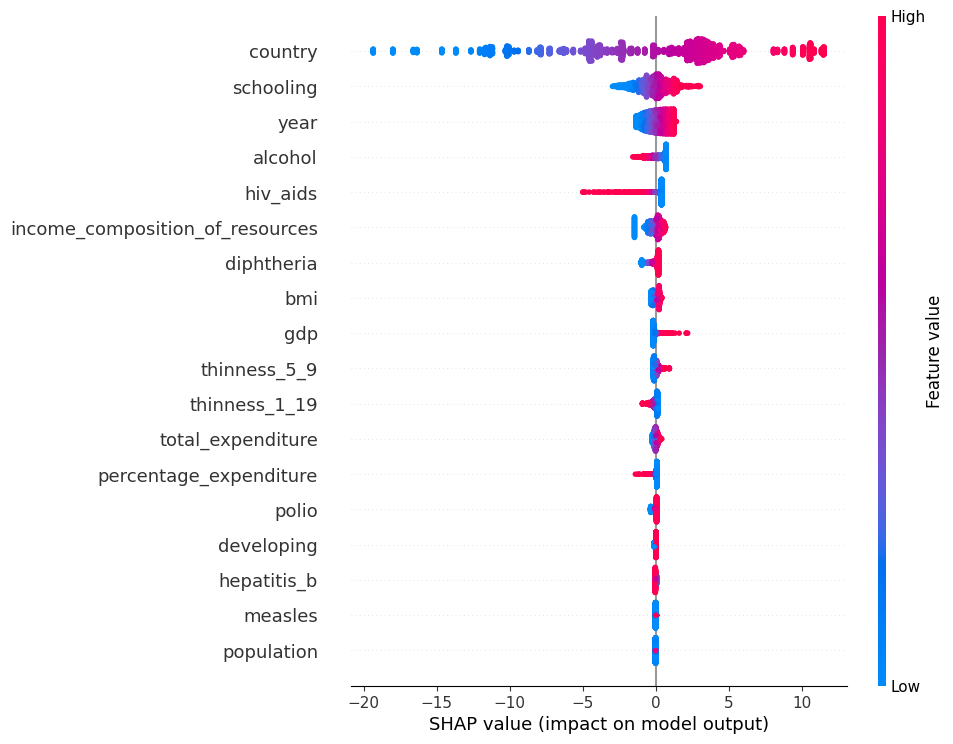

In [21]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values, max_display = 20)

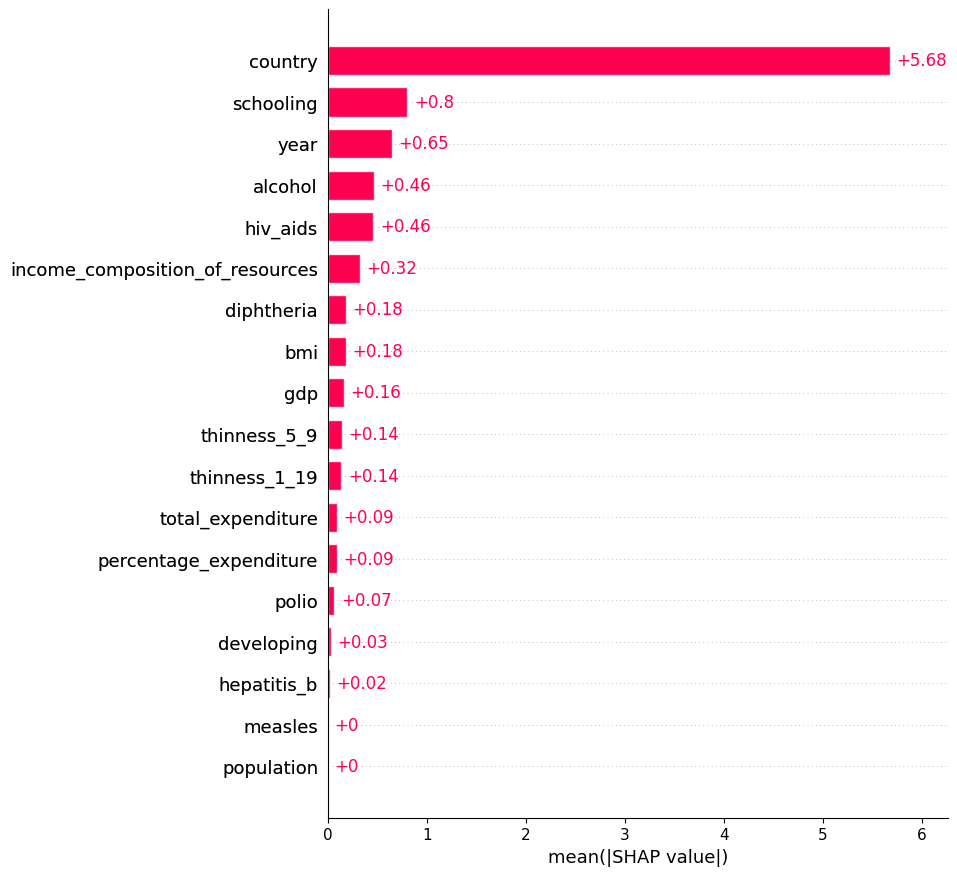

In [22]:
shap.plots.bar(shap_values, max_display = 20)